In [1]:
!rm -rf ./ML4CV_XAI
!git clone https://github.com/liuktc/ML4CV_XAI.git
!pip install captum grad_cam Craft-xai torcheval
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('/kaggle/working/ML4CV_XAI')

Cloning into 'ML4CV_XAI'...
remote: Enumerating objects: 818, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 818 (delta 6), reused 19 (delta 5), pack-reused 789 (from 1)
Receiving objects: 100% (818/818), 63.56 MiB | 39.13 MiB/s, done.
Resolving deltas: 100% (359/359), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 38.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 31.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 12.2 MB/s eta 0:00:00
  Created wheel for grad_cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39680 sha256=0a68309590a3edf4e79646b401573e3d306ac48f301b6b3a2c46364d5a4b2a7a
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successf

In [77]:
%load_ext autoreload

%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader

from utils import _DeepLiftShap, _GradCAMPlusPlus, SimpleUpsampling,ERFUpsamplingFast, min_max_normalize, ERFUpsampling
from data import imagenettewoof, SynteticFigures
from results.results_metrics import ResultMetrics
from models import vgg11_PascalVOC, vgg_preprocess, vgg11_Imagenettewoof, vgg11_Syntetic

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
torch.manual_seed(123)
np.random.seed(123)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# model = vgg11_Imagenettewoof()
model = vgg11_Syntetic()
model.to(device)
# Load the pretrained weights
# model.load_state_dict(torch.load('./VGG11_Imagenettewoof.pth', map_location=device))
model.load_state_dict(torch.load('./VGG11_Synthetic.pt', map_location=device))
model.eval()

preprocess = vgg_preprocess

In [86]:
# train_data = imagenettewoof(split="train",size="320px",download=False, transform=preprocess)
# test_data = imagenettewoof(split="test",size="320px", download=False, transform=preprocess)
from data import SynteticFigures, BlurImagePerlinNoise, Binarize
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
from models import vgg_preprocess

TRAIN_SIZE = 8
TEST_SIZE = 6 * 50
BATCH_SIZE = 1



background_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.15, saturation=0.15, hue=0.15),
])

mask_preprocess = transforms.Compose([
        transforms.Resize((224, 224), interpolation=InterpolationMode.NEAREST),
        transforms.GaussianBlur(kernel_size=15),
        transforms.ToTensor(),  # Convert to Tensor
        Binarize(),
])

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomResizedCrop(224),        # Random crop + resize
    transforms.RandomHorizontalFlip(),        # Random flip
    transforms.ColorJitter(0.3, 0.3, 0.3),    # Color variations
    transforms.RandomRotation(15),            # Slight rotation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_data = SynteticFigures(background_path="./data/WaldoNoise",
                            num_images=TRAIN_SIZE,
                            split='train',
                            num_shapes_per_image=1,
                            image_transform=train_transform,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            size_range=(80, 100))

test_data = SynteticFigures(background_path="./data/WaldoNoise",
                            num_images=TEST_SIZE,
                            split='test',
                            num_shapes_per_image=1,
                            image_transform=vgg_preprocess,
                            background_transform=background_transform,
                            mask_preprocess=mask_preprocess,
                            size_range=(80, 100))

In [87]:
###########################################
###########################################
###########################################
###########################################
## TO CHANGE IN KAGGLE
INDEX = 0 # 0,1,2,3
###########################################
###########################################
###########################################
###########################################

# Number of parts to split the dataset into
num_parts = 2

# Get the total number of images in the dataset
total_size = len(test_data)

# Split the dataset indices into roughly equal parts
split_indices = np.array_split(np.arange(total_size), num_parts)

INDICES = split_indices[INDEX]

In [88]:
import torch.utils
from torch.utils.data import Subset

# BATCH_SIZE_TEST = 1

BATCH_SIZE_TRAIN = 2
NUM_TRAIN = 16

# dl_test = DataLoader(test_data, batch_size=BATCH_SIZE_TEST, shuffle=False)
dl_train = DataLoader(Subset(train_data, torch.randperm(len(train_data))[:NUM_TRAIN]), batch_size=BATCH_SIZE_TRAIN, shuffle=False)

In [89]:
baseline_dist_16 = torch.cat([images for images, _, _ in dl_train], dim=0).to(device)
baseline_dist_8 = baseline_dist_16[:8].clone()
baseline_dist_4 = baseline_dist_16[:4].clone()

In [90]:
LAYERS = [20,15,10,5]
# LAYERS = [20]

Results loaded from ./results_mixed_synth_fake.csv.


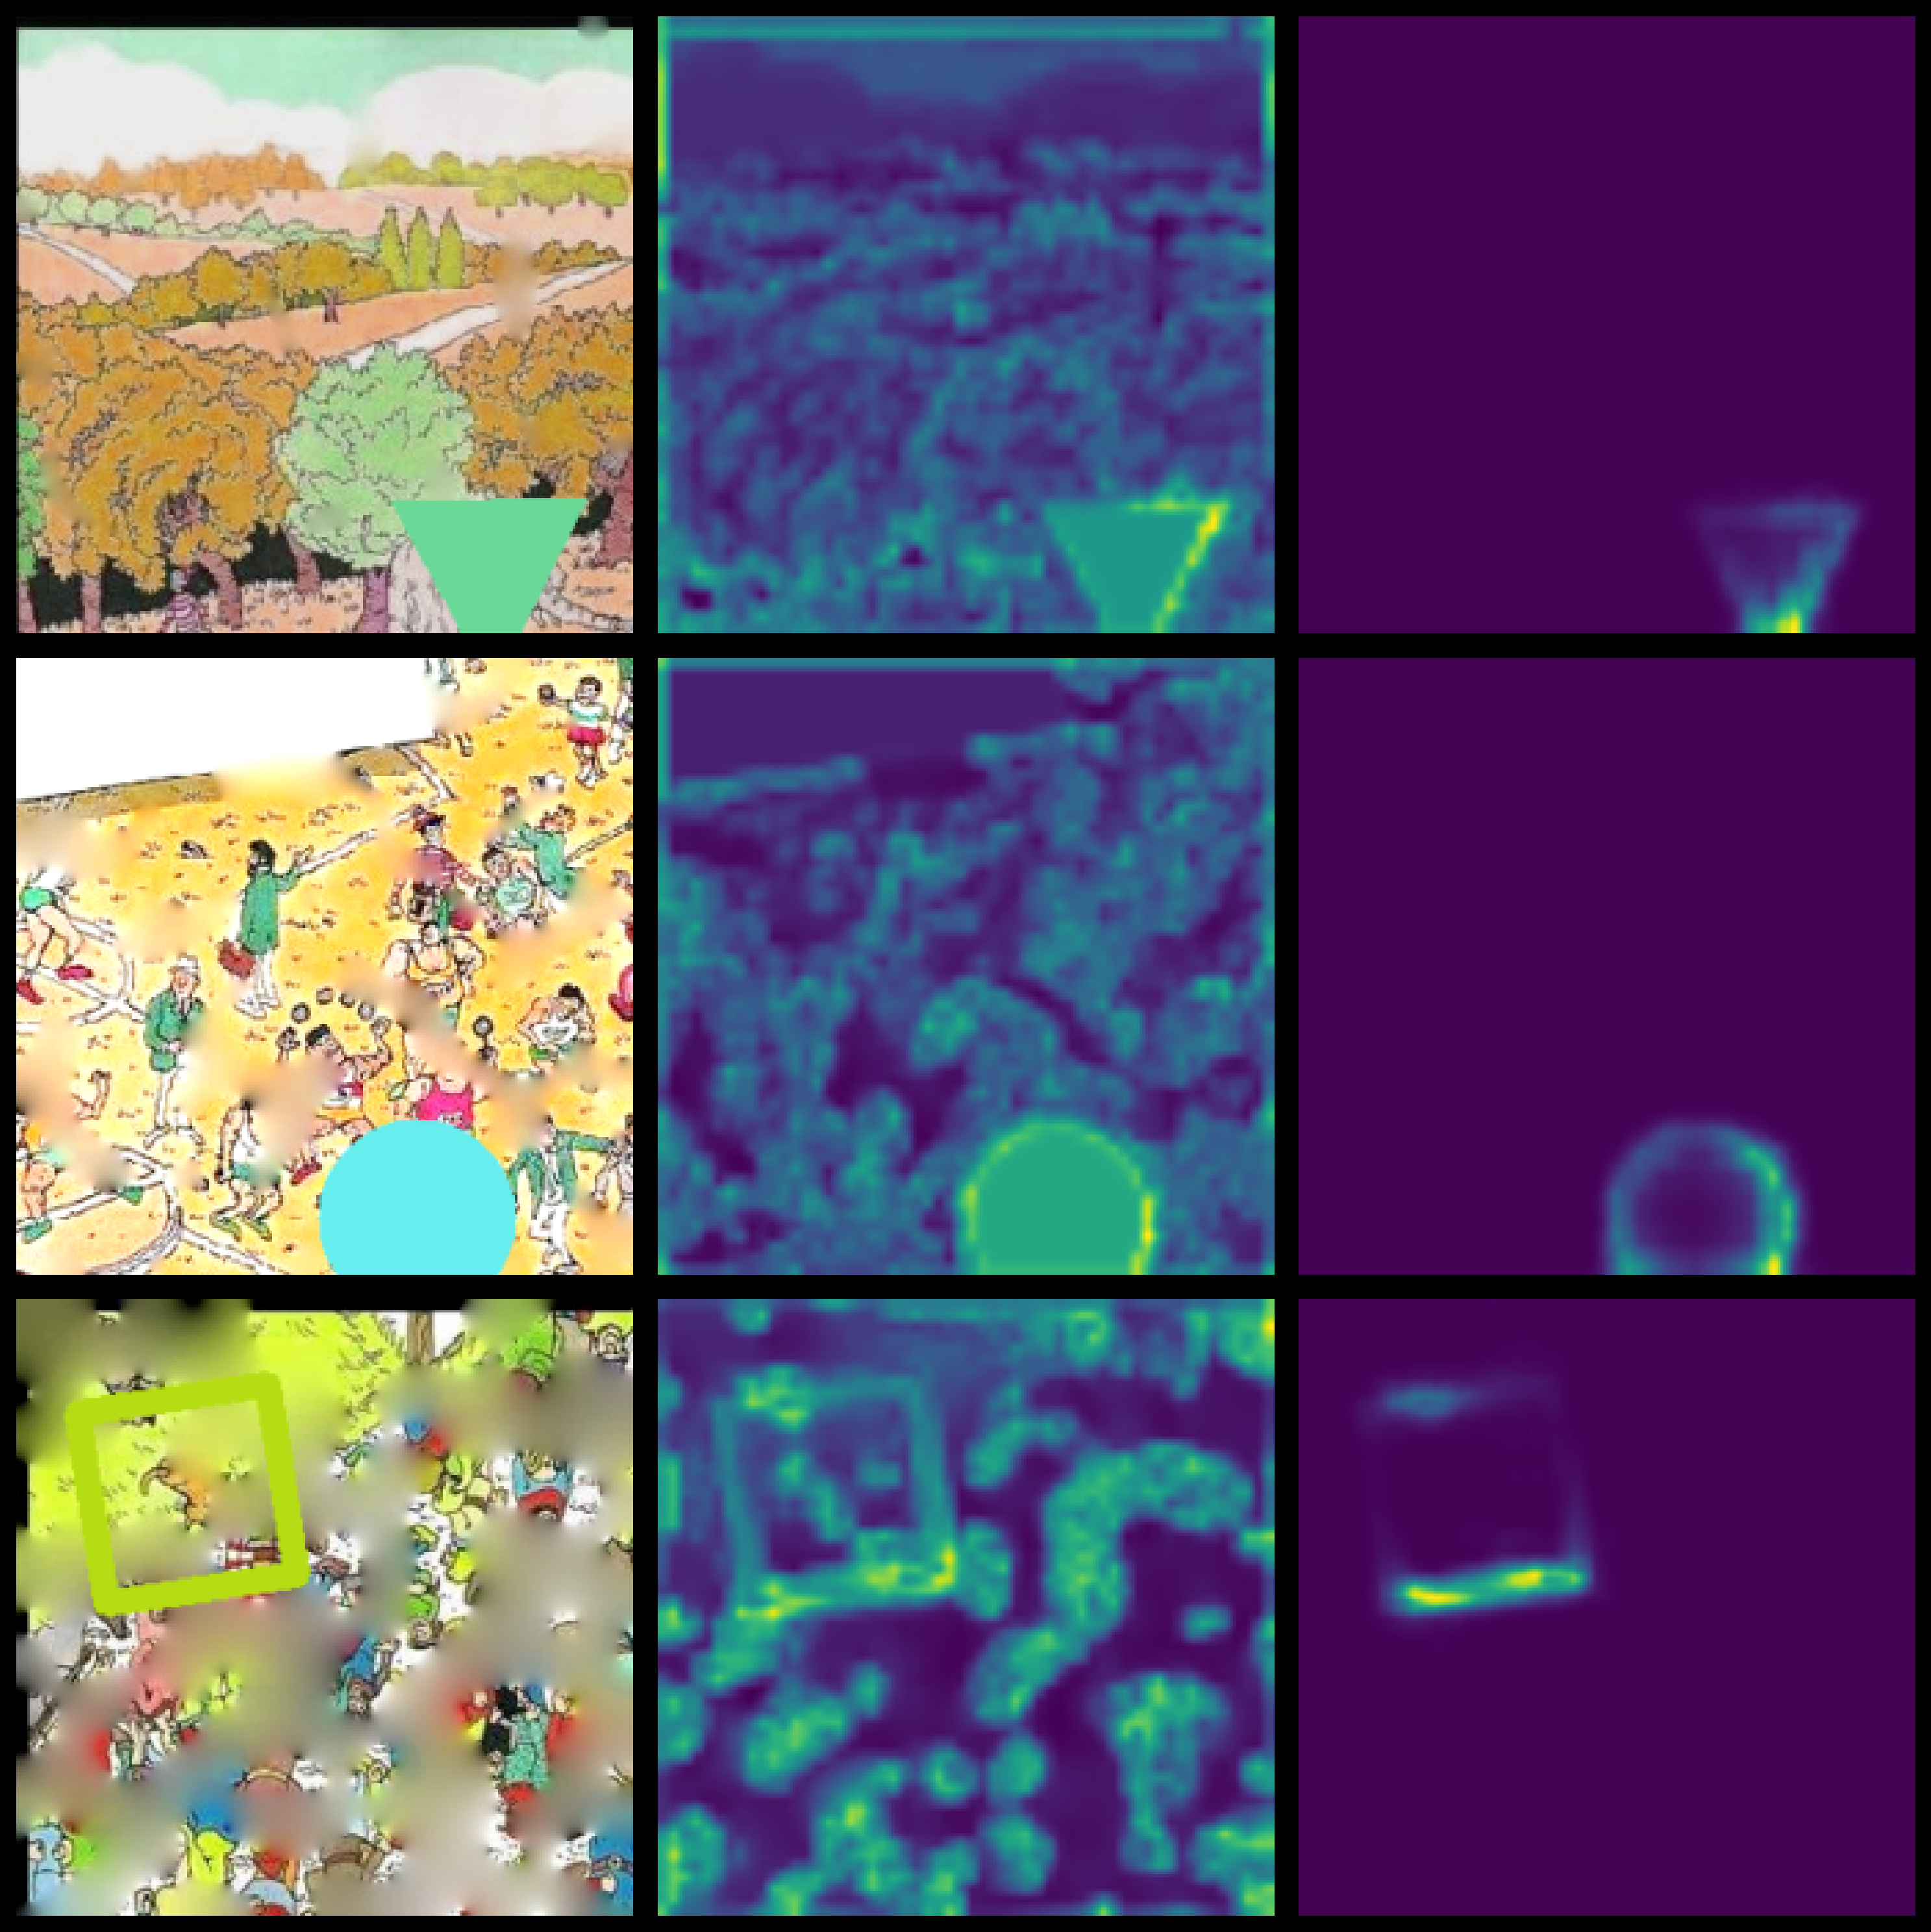

In [94]:
from metrics import RoadCombined, AverageDrop, InsertionCurveAUC, DeletionCurveAUC, Coherency, Complexity, Infidelity, ROC_AUC
from utils import MultiplierMix, _ScoreCAM, _EigenCAM, _LayerCAM, IdentityMix, _ShapleyCAM
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

results = ResultMetrics("./results_mixed_synth_fake.csv")
# dark theme
plt.style.use('dark_background')

last_image_index = results.get_last_image_index()

# plt.figure(figsize=(12, 4), dpi=300)

# for index in tqdm(INDICES[1:]):
INDICES = [0,50, 100]
plt.figure(figsize=(12, 4 * len(INDICES)), dpi=250)
for num_image, index in enumerate(INDICES):
    if index < last_image_index:
        continue
    if len(test_data[index]) == 2:
        images, labels = test_data[index]
        mask = None
    elif len(test_data[index]) == 3:
        images, mask, labels = test_data[index]
        mask = mask.unsqueeze(0)
    else:
        raise ValueError("Invalid number of elements in test_data[index]")

    images = images.unsqueeze(0)  # Add batch dimension
    labels = torch.Tensor([labels]).long()  # Convert to long tensor    
    images = images.to(device)
    labels = labels.to(device).reshape(-1)

    predicted_label = model(images).argmax(dim=1)

    # Make sure that LAYERS is sorted in descending order
    LAYERS.sort(reverse=True)
    for  attribution_method in [_GradCAMPlusPlus()]:
    # for attribution_method in [_ShapleyCAM()]:
    # for j, attribution_method in enumerate([_ScoreCAM(), _LayerCAM(), _GradCAMPlusPlus()]):
        # plt.subplot(1,3,j+1)
        # plt.title(attribution_method.name)
        # plt.axis('off')

        # for j, upsample_method in enumerate([ERFUpsampling(model, layer)]):
        for upsample_method in [SimpleUpsampling((224,224))]:
            attributions_per_layer = []
            for layer_index in LAYERS:
                    
                layer = model.features[layer_index]
                attribution_map = attribution_method.attribute(input_tensor=images,
                                                                model=model,
                                                                layer=layer,
                                                                target=labels
                                                                )

                # upsample_method = SimpleUpsampling((224,224))~
                # from PIL import Image
                # from matplotlib import cm
                # commonly_used_colormap = cm.viridis
                # attribution_map_colored = commonly_used_colormap(attribution_map[0][0].cpu().detach().numpy())
                # attribution_map_colored_uint8 = (attribution_map_colored[:, :, :3] * 255).astype(np.uint8)
                # im_colored = Image.fromarray(attribution_map_colored_uint8, 'RGB')
                # im_colored.save(f"./output/attribution_map_layer_{layer_index}_{upsample_method.name}_small.png")
                
                # upsample_method = ERFUpsampling()
                attribution_map = upsample_method(attribution=attribution_map,
                                                  image=images,
                                                  device=device,
                                                  model=model,
                                                  layer=layer,
                                                  )
                
                # print(erf.shape)
                # erf = torch.from_numpy(erf).to(device)
                # erf = erf.sum(dim=2)
                # for i in range(7):
                #     for j in range(7):
                #         erf_colored = commonly_used_colormap(erf[i][j].cpu().detach().numpy())
                #         erf_colored_uint8 = (erf_colored[:, :, :3] * 255).astype(np.uint8)
                #         im_colored = Image.fromarray(erf_colored_uint8, 'RGB')
                #         im_colored.save(f"./output/erf_{i}_{j}.png")
                # assert(False)

                # if (torch.abs(
                #     attribution_map.amax(dim=(2, 3), keepdim=True)
                #     - attribution_map.amin(dim=(2, 3), keepdim=True)
                # )
                # < 1e-6  ).any():
                #     print("A saliency map is constant, skipping batch")
                #     del images, labels, attribution_map
                #     torch.cuda.empty_cache()
                #     continue

                attribution_map = min_max_normalize(attribution_map)
                attributions_per_layer.append(attribution_map)

                # # Mix the attribution maps
                mix = MultiplierMix(layers_to_combine="all")
                mixed_attribution_map = mix(attributions_per_layer)
                mixed_attribution_map = min_max_normalize(mixed_attribution_map)

                # Unstandardize the image
                std_images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
                # plt.imshow(std_images[0].permute(1, 2, 0).cpu().detach().numpy())
                
                # if layer_index == 5:
                #     plt.subplot(1, 2, 1)
                # plt.imshow(attribution_map[0][0].cpu().detach().numpy(), cmap='viridis')
                #     plt.title("Attribution Map NOT Filtered")
                # plt.axis('off')
                #     plt.subplot(1, 2, 2)
                #     plt.imshow(mixed_attribution_map[0][0].cpu().detach().numpy(), cmap='viridis')
                #     plt.title("Attribution Map Filtered")
                #     plt.axis('off')
                #     plt.tight_layout()
                # plt.figure(figsize=(15, 5), dpi=300)
                # plt.subplot(1,3,1)
                # plt.imshow(std_images[0].permute(1, 2, 0).cpu().detach().numpy())
                # plt.axis('off')
                # plt.title("Input Image")
                # plt.subplot(1,3,2)
                # plt.imshow(attribution_map[0][0].cpu().detach().numpy(), cmap='viridis')
                # plt.colorbar()
                # plt.axis('off')
                # plt.title(f"Attribution Map") 

                # plt.subplot(1,3,3)
                # #Overlay the attribution map on the image
                # # overlayed = std_images[0].permute(1, 2, 0).cpu().detach().numpy() * 0.5 + attribution_map[0][0].cpu().detach().numpy() * 0.5
                # plt.imshow(std_images[0].permute(1, 2, 0).cpu().detach().numpy(), alpha=0.5)
                # plt.imshow(attribution_map[0][0].cpu().detach().numpy(), cmap='viridis', alpha=0.5) 
                # plt.axis('off')
                # plt.title(f"Overlayed Attribution Map")

                # plt.tight_layout()
                # plt.savefig(f"./output/attribution_example.png")
                # plt.show()               

                # plt.subplot(1, 3, 1)
                from PIL import Image
                from matplotlib import cm
                image_numpy_uint8 = (std_images[0].permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
                im = Image.fromarray(image_numpy_uint8, 'RGB')
                # im.save(f"./output/image_{index}.png")
                # plt.imshow(std_images[0].permute(1, 2, 0).cpu().detach().numpy())
                # plt.show()

                commonly_used_colormap = cm.viridis
                attribution_map_colored = commonly_used_colormap(attribution_map[0][0].cpu().detach().numpy())
                attribution_map_colored_uint8 = (attribution_map_colored[:, :, :3] * 255).astype(np.uint8)
                im_colored = Image.fromarray(attribution_map_colored_uint8, 'RGB')
                # im_colored.save(f"./output/attribution_map_layer_{layer_index}_{index}.png")
                # plt.imshow(attribution_map_colored_uint8)
                # plt.show()

                # # Overlay the attribution map on the image
                overlay = Image.blend(im.convert("RGBA"), im_colored.convert("RGBA"), alpha=0.5)
                # overlay.save(f"./output/attribution_map_layer_{layer_index}_{index}_overlay.png")

                mixed_attribution_map_colored = commonly_used_colormap(mixed_attribution_map[0][0].cpu().detach().numpy())
                mixed_attribution_map_colored_uint8 = (mixed_attribution_map_colored[:, :, :3] * 255).astype(np.uint8)
                im_mixed_colored = Image.fromarray(mixed_attribution_map_colored_uint8, 'RGB')
                # im_mixed_colored.save(f"./output/mixed_attribution_map_layer_{layer_index}_{index}.png")
                # plt.imshow(mixed_attribution_map_colored_uint8)
                # plt.show()

                if layer_index == 5:
                    plt.subplot(len(INDICES),3,num_image*3 + 1)
                    if num_image==0:
                        pass
                        # plt.title("Input Image")
                    plt.imshow(std_images[0].permute(1, 2, 0).cpu().detach().numpy())
                    plt.axis('off')
                    plt.subplot(len(INDICES),3,num_image*3 + 2)
                    if num_image==0:
                        pass
                        # plt.title("GradCAM++")
                    plt.imshow(attribution_map_colored_uint8)
                    plt.axis('off')
                    plt.subplot(len(INDICES),3,num_image*3 + 3)
                    if num_image==0:
                        pass
                        # plt.title("HighResCAM(GradCAM++)")
                    plt.imshow(mixed_attribution_map_colored_uint8)
                    plt.axis('off')
                    plt.tight_layout()
                    # plt.savefig("./output/filtered_vs_unfiltered.pdf", bbox_inches='tight', dpi=300)


                # # Overlay the mixed attribution map on the image
                # overlay_mixed = Image.blend(im.convert("RGBA"), im_mixed_colored.convert("RGBA"), alpha=0.5)
                # overlay_mixed.save(f"./output/mixed_attribution_map_layer_{layer_index}_overlay.png")
                
                # for metric in [ROC_AUC(), DeletionCurveAUC(), InsertionCurveAUC(), Infidelity(), AverageDrop(), Coherency(), Complexity()]:
                #     metric_result_normal = metric(model=model,
                #             test_images=images,
                #             saliency_maps=attribution_map,
                #             class_idx=labels,
                #             attribution_method=attribution_method,
                #             device=device,
                #             layer=layer,
                #             upsample_method=upsample_method,
                #             mixer=IdentityMix(),
                #             previous_attributions=attributions_per_layer[:-1],
                #             mask=mask)

                #     if type(metric_result_normal) is torch.Tensor:
                #         metric_result_normal = metric_result_normal.item()
                    
                #     results.add_result(model="VGG11",
                #                        attribution_method=attribution_method.name,
                #                        dataset="Synthetic",
                #                        layer=f"features.{layer_index}",
                #                        metric=metric.name,
                #                        upscale_method=upsample_method.name,
                #                        mixing_method= "None",
                #                        value=metric_result_normal,
                #                        image_index=index,
                #                        label=labels[0].item(),
                #                        predicted_label=predicted_label[0].item())

                #     metric_result_mixed = metric(model=model,
                #             test_images=images,
                #             saliency_maps=mixed_attribution_map,
                #             class_idx=labels,
                #             attribution_method=attribution_method,
                #             device=device,
                #             layer=layer,
                #             upsample_method=upsample_method,
                #             mixer=mix,
                #             previous_attributions=attributions_per_layer[:-1],
                #             mask=mask)

                #     if type(metric_result_mixed) is torch.Tensor:
                #         metric_result_mixed = metric_result_mixed.item()
                    
                    
                #     results.add_result(model="VGG11",
                #                        attribution_method=attribution_method.name,
                #                        dataset="Synthetic",
                #                        layer=f"features.{layer_index}",
                #                        metric=metric.name,
                #                        upscale_method=upsample_method.name,
                #                        mixing_method= mix.name,
                #                        value=metric_result_mixed,
                #                        image_index=index,
                #                        label=labels[0].item(),
                #                        predicted_label=predicted_label[0].item())
plt.savefig(f"./output/qualitativi_synthetic_dark.png", bbox_inches='tight', dpi=300)
# results.save_results()

In [49]:
attribution_map.shape

torch.Size([1, 1, 7, 7])

In [52]:
summed_erf = torch.zeros((224,224), dtype=torch.float32)
for i in range(7):
    for j in range(7):
        summed_erf += erf[i][j] * attribution_map[0][0][i][j]
        # save summed erf as image
        erf_colored = commonly_used_colormap(summed_erf.cpu().detach().numpy())
        erf_colored_uint8 = (erf_colored[:, :, :3] * 255).astype(np.uint8)
        im_colored = Image.fromarray(erf_colored_uint8, 'RGB')
        im_colored.save(f"./output/erf_sum_{i}_{j}.png")
        
        # plt.imshow(summed_erf.cpu().detach().numpy(), cmap='viridis')
        # plt.show()